In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import math
from fbprophet import Prophet
import datetime

In [141]:
os.chdir('/Users/clairesun/desktop/Sales_Forecast')

In [142]:
df_sales['date'] = pd.to_datetime(df_sales['date'],dayfirst=True)

In [143]:
#Data Cleansing,fill-in negative prices with mean
mean = int(df_sales.loc[df_sales['item_id']==2973, 'item_price'].mean())
df_sales["item_price"] = df_sales["item_price"].mask(df_sales["item_price"] <0, mean)

#New Items launched after 2015-06-01
df_sales_recent = df_sales[df_sales.date>'2015-05-31']
df_item1 = df_sales_recent.drop(['date', 'date_block_num','shop_id','item_price','item_cnt_day'], axis=1)
df_item2=df_item1.drop_duplicates()
df_sales_recent_5m = pd.merge(left=df_item2,right=df_sales, how='left', left_on='item_id', right_on='item_id')

In [144]:
#Define New Items (launched after 2015-06-01) & Old Items (launched before 2015-06-01)
df_sales_old = df_sales[df_sales.date<'2015-06-01']
df_item_old = df_sales_old.drop(['date', 'date_block_num','shop_id','item_price','item_cnt_day'], axis=1)
df_item3=df_item_old.drop_duplicates()
df_item3=df_item3.reset_index(drop=True)
old_items=pd.merge(df_item2, df_item3, on='item_id', how='inner')
df_sales_clean_old_items = pd.merge(left=old_items,right=df_sales, how='left', left_on='item_id', right_on='item_id')
df_sales_clean_old_items = df_sales_clean_old_items[df_sales_clean_old_items.item_price<40000]
df_sales_clean_all_items = df_sales_recent_5m[df_sales_recent_5m.item_price<40000]
df_item4=df_item2.merge(old_items, 'outer', indicator=True).query('_merge == "left_only"')
df_item4=df_item4.drop(['_merge'], axis=1)
df_item4=df_item4.reset_index(drop=True)
new_items=pd.merge(df_item2, df_item4, on='item_id', how='inner')
df_sales_clean_new_items = pd.merge(left=new_items,right=df_sales, how='left', left_on='item_id', right_on='item_id')
df_sales_clean_new_items = df_sales_clean_new_items[df_sales_clean_new_items.item_price<40000]
df_sales_clean_new_items

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day
0,1814,2015-06-30,29,35,3599.000000,2.0
1,1814,2015-06-29,29,35,3599.000000,2.0
2,1814,2015-06-27,29,35,3599.000000,1.0
3,1814,2015-06-24,29,35,3509.000000,4.0
4,1814,2015-06-23,29,35,3492.636364,22.0
5,1814,2015-06-28,29,34,3599.000000,2.0
6,1814,2015-06-27,29,34,3599.000000,1.0
7,1814,2015-06-26,29,34,3599.000000,1.0
8,1814,2015-06-25,29,34,3599.000000,1.0
9,1814,2015-06-24,29,34,3419.000000,1.0


In [9]:
# Old items which sales were declining by time. Prophet Model: a.drop 1st month's sales  b.cap=max('y')  c.daily_seasonality=False & yearly_seasonality=True
import datetime
df_sales_fbprophet= df_sales_clean_all_items.loc[(df_sales_clean_all_items['item_id']==20949)]

df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet.sort_values(by=['ds'])

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ds,date_block_num,y
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [10]:
df_sales_fbprophet=df_sales_fbprophet.loc[(df_sales_fbprophet['date_block_num']<33)]

,ds,date_block_num,y
0,2013-04-30,3,255.0
1,2013-05-31,4,3727.0
2,2013-06-30,5,8424.0
3,2013-07-31,6,7269.0
4,2013-08-31,7,7296.0
5,2013-09-30,8,7945.0
6,2013-10-31,9,7738.0
7,2013-11-30,10,8537.0
8,2013-12-31,11,12557.0
9,2014-01-31,12,7329.0


In [12]:
#Always drop sales from the first month got launched
df_sales_fbprophet=df_sales_fbprophet.drop(df_sales_fbprophet['y'].idxmax())

In [13]:
df_sales_fbprophet_train=df_sales_fbprophet

In [14]:
df_sales_fbprophet_train['floor']=0
df_sales_fbprophet_train['cap']=df_sales_fbprophet_train['y'].mean()

In [16]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, growth='logistic',seasonality_mode='multiplicative')
m.fit(df_sales_fbprophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.


In [26]:
future = m.make_future_dataframe(periods=5, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet_train['y'].max()

future.tail()

,ds,floor,cap
28,2015-10-31,0,8537.0
29,2015-11-30,0,8537.0
30,2015-12-31,0,8537.0
31,2016-01-31,0,8537.0
32,2016-02-29,0,8537.0


In [27]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
28,2015-10-31,3954.742135,3440.435446,4489.609898
29,2015-11-30,4987.436723,4446.065570,5565.190906
30,2015-12-31,-14665.316534,-15199.627591,-14142.805507
31,2016-01-31,5490.559414,4958.664393,6011.040762
32,2016-02-29,3355.833295,2770.154740,3885.357266


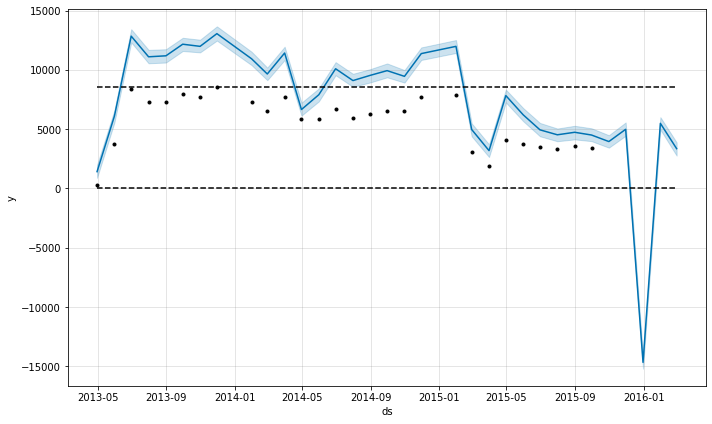

In [28]:
fig1 = m.plot(forecast)

In [46]:
# New items, launched between 2015-05-01 to 2015-07-30. Prophet Model: a.drop 1st month's sales  b.cap=max('y')  c.daily_seasonality=True & yearly_seasonality=False
import datetime
df_sales_fbprophet= df_sales_clean_all_items.loc[(df_sales_clean_all_items['item_id']==10210)]

df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet.sort_values(by=['ds'])

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ds,date_block_num,y
0,2015-05-31,28,3275.0
1,2015-06-30,29,764.0
2,2015-07-31,30,332.0
3,2015-08-31,31,242.0
4,2015-09-30,32,122.0
5,2015-10-31,33,141.0


In [47]:
df_sales_fbprophet=df_sales_fbprophet.loc[(df_sales_fbprophet['date_block_num']<33)]


In [48]:
df_sales_fbprophet=df_sales_fbprophet.drop(df_sales_fbprophet['y'].idxmax())
df_sales_fbprophet

,ds,date_block_num,y
1,2015-06-30,29,764.0
2,2015-07-31,30,332.0
3,2015-08-31,31,242.0
4,2015-09-30,32,122.0


In [49]:
df_sales_fbprophet_train=df_sales_fbprophet

In [50]:
df_sales_fbprophet_train['floor']=0
df_sales_fbprophet_train['cap']=df_sales_fbprophet_train['y'].max()

In [55]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, growth='logistic',seasonality_mode='multiplicative')
m.fit(df_sales_fbprophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


In [56]:
future = m.make_future_dataframe(periods=5, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet_train['y'].max()

future.tail()

,ds,floor,cap
4,2015-10-31,0,764.0
5,2015-11-30,0,764.0
6,2015-12-31,0,764.0
7,2016-01-31,0,764.0
8,2016-02-29,0,764.0


In [57]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
4,2015-10-31,104.877625,54.745296,158.724603
5,2015-11-30,52.506043,1.982517,102.104587
6,2015-12-31,25.616104,-23.541553,75.633996
7,2016-01-31,12.479895,-38.269491,65.490584
8,2016-02-29,6.364820,-48.172230,57.300283


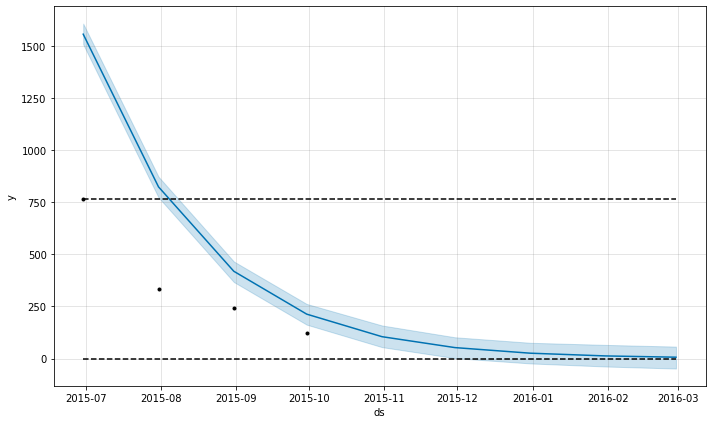

In [58]:
fig1 = m.plot(forecast)

In [77]:
#Old items, strong yearly seasonality factor. * 'Cap' value needs to be fixed, which uses mean value of the latest 11 months.
df_sales_fbprophet2 = df_sales_clean_old_items.loc[(df_sales['item_id']==17717)]

df_sales_fbprophet2['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet2['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet2 = df_sales_fbprophet2.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet2 = df_sales_fbprophet2.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet2.sort_values(by=['ds'])

df_sales_fbprophet2

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ds,date_block_num,y
0,2013-01-31,0,46.0
2,2013-03-31,2,26.0
3,2013-04-30,3,37.0
4,2013-05-31,4,46.0
5,2013-06-30,5,26.0
6,2013-07-31,6,24.0
7,2013-08-31,7,27.0
8,2013-09-30,8,92.0
9,2013-10-31,9,16.0
10,2013-11-30,10,16.0


In [79]:
df_sales_fbprophet2=df_sales_fbprophet2.drop(df_sales_fbprophet2['y'].idxmax())
df_sales_fbprophet2

,ds,date_block_num,y
0,2013-01-31,0,46.0
2,2013-03-31,2,26.0
3,2013-04-30,3,37.0
4,2013-05-31,4,46.0
5,2013-06-30,5,26.0
6,2013-07-31,6,24.0
7,2013-08-31,7,27.0
8,2013-09-30,8,92.0
9,2013-10-31,9,16.0
10,2013-11-30,10,16.0


In [80]:
df_sales_fbprophet_train = df_sales_fbprophet2.loc[(df_sales_fbprophet2['ds']<'2015-10-31')]
df_sales_fbprophet_train['floor']=0
df_sales_fbprophet_train['cap']=df_sales_fbprophet_train['y'].mean()

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, growth='logistic',seasonality_mode='multiplicative')
m.fit(df_sales_fbprophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [86]:
future = m.make_future_dataframe(periods=5, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet_train.loc[(df_sales_fbprophet_train['ds']>'2014-10-31')].mean()

future.tail()

,ds,floor,cap
31,2015-10-31,0,NaN
32,2015-11-30,0,NaN
33,2015-12-31,0,NaN
34,2016-01-31,0,NaN
35,2016-02-29,0,NaN


In [83]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
31,2015-10-31,42.219022,29.489913,55.354148
32,2015-11-30,145.901947,133.018360,158.551140
33,2015-12-31,44.878178,31.341910,58.778049
34,2016-01-31,68.242716,54.670198,81.394372
35,2016-02-29,59.918341,48.056884,73.245139


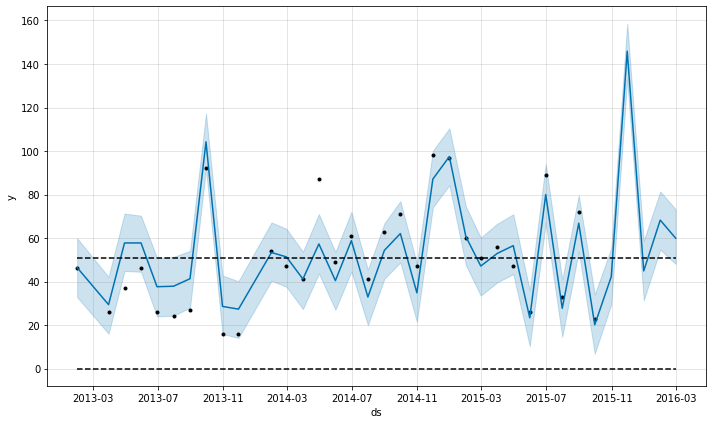

In [84]:
fig2 = m.plot(forecast)

In [109]:
#New items, launched after 2015-08-01
import datetime
df_sales_fbprophet_new = df_sales_clean_all_items.loc[(df_sales_clean_all_items['item_id']==10210)]

df_sales_fbprophet_new['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet_new['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet_new = df_sales_fbprophet_new.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet_new = df_sales_fbprophet_new.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet_new.sort_values(by=['ds'])

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ds,date_block_num,y
0,2015-05-31,28,3275.0
1,2015-06-30,29,764.0
2,2015-07-31,30,332.0
3,2015-08-31,31,242.0
4,2015-09-30,32,122.0
5,2015-10-31,33,141.0


In [110]:
df_sales_fbprophet_new=df_sales_fbprophet_new.loc[(df_sales_fbprophet_new['date_block_num']<33)]

df_sales_fbprophet_new.head(10)

,ds,date_block_num,y
0,2015-05-31,28,3275.0
1,2015-06-30,29,764.0
2,2015-07-31,30,332.0
3,2015-08-31,31,242.0
4,2015-09-30,32,122.0


In [114]:
df_sales_fbprophet_new=df_sales_fbprophet_new.drop(df_sales_fbprophet_new['y'].idxmax())
df_sales_fbprophet_new

,ds,date_block_num,y
1,2015-06-30,29,764.0
2,2015-07-31,30,332.0
3,2015-08-31,31,242.0
4,2015-09-30,32,122.0


In [115]:
df_sales_fbprophet_new['floor']=0
df_sales_fbprophet_new['cap']=df_sales_fbprophet_new['y'].max()

In [126]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False,
            growth='logistic',seasonality_mode='multiplicative')
m.fit(df_sales_fbprophet_new)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


In [127]:
days_to_predict = pd.to_datetime('2015-12-31') - df_sales_fbprophet_new['ds'].max()
months_to_predict = round(days_to_predict.days/31)

In [128]:
future = m.make_future_dataframe(periods=months_to_predict, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet_new['y'].max()

future.tail(3)

,ds,floor,cap
4,2015-10-31,0,764.0
5,2015-11-30,0,764.0
6,2015-12-31,0,764.0


In [129]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
2,2015-08-31,200.419147,151.702813,252.724439
3,2015-09-30,103.545346,53.010322,154.802606
4,2015-10-31,51.981166,4.288360,102.192054
5,2015-11-30,26.592909,-22.133696,76.102542
6,2015-12-31,13.280812,-34.748371,62.770612


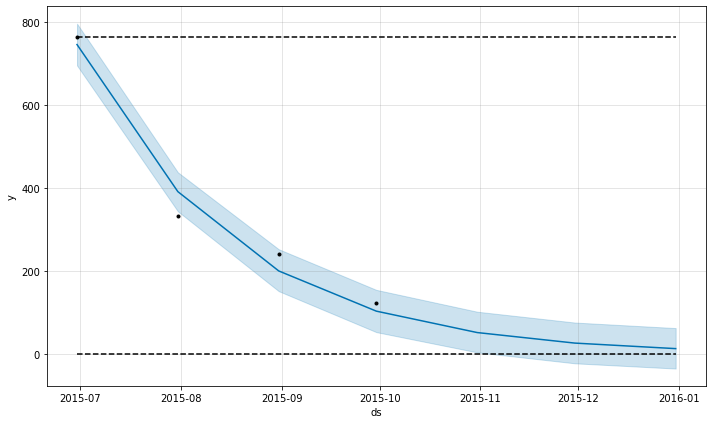

In [130]:
fig1 = m.plot(forecast)

In [95]:
forecast[['ds','yhat']]

,ds,yhat
0,2015-05-31,3251.814622
1,2015-06-30,881.349710
2,2015-07-31,215.882044
3,2015-08-31,52.077962
4,2015-09-30,13.105606
5,2015-10-31,3.146981
6,2015-11-30,0.791084
7,2015-12-31,0.189906


In [171]:
#New items lauched after 2015-08-01 will need to be predicted by day
df_sales_fbprophet = df_sales_clean_new_items.loc[(df_sales_clean_new_items['item_id']==3351)&(df_sales_clean_new_items['date_block_num']<34)]
                                

df_sales_fbprophet_new.head(10)
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet

,date,item_cnt_day_total
0,2015-09-22,926.0
1,2015-09-23,188.0
2,2015-09-24,135.0
3,2015-09-25,90.0
4,2015-09-26,88.0
5,2015-09-27,50.0
6,2015-09-28,42.0
7,2015-09-29,27.0
8,2015-09-30,23.0
9,2015-10-01,32.0


In [172]:
df_sales_fbprophet=df_sales_fbprophet.drop(df_sales_fbprophet['item_cnt_day_total'].idxmax())

In [201]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=df_sales_fbprophet['y'].min()
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
1,2015-09-23,188.0,3.0,188.0
2,2015-09-24,135.0,3.0,188.0
3,2015-09-25,90.0,3.0,188.0
4,2015-09-26,88.0,3.0,188.0
5,2015-09-27,50.0,3.0,188.0
6,2015-09-28,42.0,3.0,188.0
7,2015-09-29,27.0,3.0,188.0
8,2015-09-30,23.0,3.0,188.0
9,2015-10-01,32.0,3.0,188.0
10,2015-10-02,30.0,3.0,188.0


In [204]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, 
            seasonality_mode='multiplicative', growth='logistic')
m.fit(df_sales_fbprophet)

In [205]:
days_to_predict = pd.to_datetime('2015-12-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

61

In [208]:
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=1
future['cap']=df_sales_fbprophet['y'].max()

future.tail(100)

,ds,floor,cap
0,2015-09-23,1,188.0
1,2015-09-24,1,188.0
2,2015-09-25,1,188.0
3,2015-09-26,1,188.0
4,2015-09-27,1,188.0
5,2015-09-28,1,188.0
6,2015-09-29,1,188.0
7,2015-09-30,1,188.0
8,2015-10-01,1,188.0
9,2015-10-02,1,188.0


In [209]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2015-12-27,9.024350,-3.595699,21.423973
96,2015-12-28,7.788569,-4.891897,19.585846
97,2015-12-29,5.971183,-6.197408,17.352471
98,2015-12-30,14.183435,1.240246,25.894646
99,2015-12-31,12.472092,0.129727,25.025035


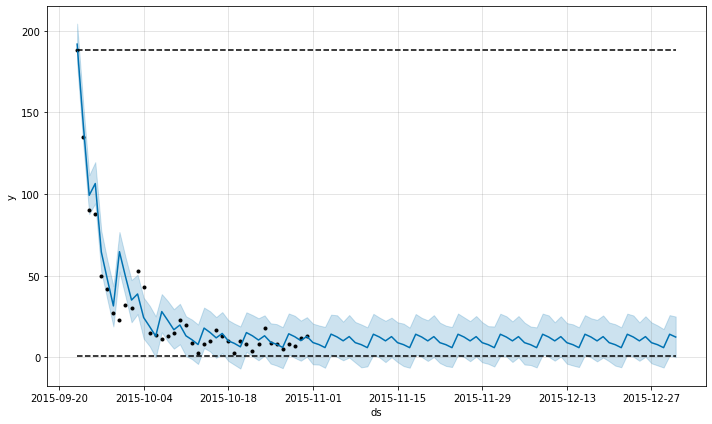

In [210]:
fig1=m.plot(forecast)

In [211]:
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-12-30'))]['yhat']

39     9.107810
40     7.848335
41     6.009201
42    14.258362
43    12.526760
44    10.160117
45    12.764766
46     9.046943
47     7.804747
48     5.981474
49    14.203717
50    12.486891
51    10.133266
52    12.736760
53     9.030465
54     7.792948
55     5.973968
56    14.188924
57    12.476097
58    10.125997
59    12.729178
60     9.026004
61     7.789753
62     5.971936
63    14.184919
64    12.473175
65    10.124030
66    12.727125
67     9.024796
68     7.788888
69     5.971386
70    14.183835
71    12.472385
72    10.123497
73    12.726570
74     9.024469
75     7.788654
76     5.971237
77    14.183542
78    12.472170
79    10.123353
80    12.726419
81     9.024381
82     7.788591
83     5.971197
84    14.183462
85    12.472112
86    10.123314
87    12.726379
88     9.024357
89     7.788574
90     5.971186
91    14.183441
92    12.472097
93    10.123303
94    12.726368
95     9.024350
96     7.788569
97     5.971183
98    14.183435
Name: yhat, dtype: float64

In [212]:
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'].sum()

306.4973522932414